# Линейное многомерное моделирование взаимосвязей

---

Определим модель **множественной регрессии** для прогнозирования *итогового балла* на основе переменных: Часы учебы/нед, Процент посещения, Результат предыдущего экзамена, Занятия с репетитором.

Ниже представлены таблицы с результатами регрессионного анализа.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

df = pd.read_csv("../data/student_perfomance_sample.csv")

X = df[["study_hours_week", "attendance_pct", "prev_exam_score", "tutoring_sessions_month"]]
y = df["final_exam_score"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

R = model.rsquared**0.5                                             
R2 = model.rsquared                                                 
F = model.fvalue                                                    
df_model = int(model.df_model)                                      
df_resid = int(model.df_resid)                                      
p_value = model.f_pvalue                                            
std_error = model.mse_resid**0.5                                    

result = pd.DataFrame({"Статистика": ["Множественное R", "Множественное R^2", f"F({df_model}, {df_resid})", "p-value", "Стандартная ошибка оценки"],
    "Значение": [R, R2, F, p_value, std_error]})
result["Значение"] = result["Значение"].apply(lambda x: f"{x:.6f}")
display(result)

params = model.params
b_se = model.bse
pvals = model.pvalues
X_std = (X - X.mean()) / X.std(ddof=0)
y_std = (y - y.mean()) / y.std(ddof=0)
X_std_const = sm.add_constant(X_std.drop('const',axis=1))
model_std = sm.OLS(y_std, X_std_const).fit()
beta = model_std.params
beta_se = model_std.bse

coeffient_table = pd.DataFrame({"БЕТА": beta, "Ст. Ош. БЕТА": beta_se, "B": params, "Ст. Ош. B": b_se, "p_value": pvals})
coeffient_table.index = ["Свободный член", "Часы учебы/нед", "Процент посещения", "Результат предыдущего экзамена", "Занятия с репетитором"]
display(coeffient_table.style.format("{:.4f}").apply(lambda row: ['color: red; font-weight: bold' if row["p_value"] < 0.05 else '' for _ in row] , axis=1))

,Статистика,Значение
0,Множественное R,0.794382
1,Множественное R^2,0.631043
2,"F(4, 939)",401.503274
3,p-value,0.000000
4,Стандартная ошибка оценки,2.290588


,БЕТА,Ст. Ош. БЕТА,B,Ст. Ош. B,p_value
Свободный член,-0.0000,0.0198,42.0180,0.6992,0.0000
Часы учебы/нед,0.4692,0.0198,0.2945,0.0125,0.0000
Процент посещения,0.6103,0.0198,0.1951,0.0063,0.0000
Результат предыдущего экзамена,0.1547,0.0198,0.0406,0.0052,0.0000
Занятия с репетитором,0.1564,0.0198,0.4689,0.0595,0.0000


Первая таблица содержит информации о качестве предсказания. Коэффициент множественной корреляции R равен 0,79, коэффициент детерминации равен 0,63. Уровень значимости p < 0,05, что говорит о статистической значимости уравнения регрессии. По коэффициенту детерминации можно сделать вывод об умеренной зависимости между откликом и предикторами.

Вторая таблица содержит стандартизованные *Бета* и не стандартизованные (*B*) регрессионные коэффициенты (веса), их стандартные ошибки и уровни значимости. Коэффициенты Beta оцениваются по стандартизованным данным, имеющим выборочное среднее, равное 0, и стандартное отклонение, равное 1. Поэтому величины Beta позволяют сравнить вклады каждого предиктора в предсказание отклика. Из таблицы видно, что в зависимую переменную Итоговый балл больший вклад вносит Процент посещения, а меньший – Результат предыдущего экзамена. Все коэффициенты уравнения регрессии статистически значимы.

In [2]:
predictors = ["study_hours_week", "attendance_pct", "prev_exam_score", "tutoring_sessions_month"]

rows = []
for j in predictors:
    
    others = [c for c in predictors if c != j]
    X_others = sm.add_constant(X[others], has_constant='add')
    resid_y = (sm.OLS(y, X_others).fit()).resid
    
    xj = X[j]
    X_others = sm.add_constant(X[others], has_constant='add')
    resid_xj = (sm.OLS(xj, X_others).fit()).resid
    
    partial_corr = np.corrcoef(resid_y, resid_xj)[0,1]
    semi_corr = np.corrcoef(y, resid_xj)[0,1]

    rows.append({"B": beta[j], "Частная корреляция": partial_corr, "Получастная корреляция": semi_corr, "p_value": pvals[j]}) 

summary = pd.DataFrame(rows)
summary.index = ["Часы учебы/нед", "Процент посещения", "Результат предыдущего экзамена", "Занятия с репетитором"]
display(summary.style.apply(lambda row: ['color: red; font-weight: bold' if row["p_value"] < 0.05 else '' for _ in row] , axis=1))

,B,Частная корреляция,Получастная корреляция,p_value
Часы учебы/нед,0.469244,0.610833,0.468616,0.000000
Процент посещения,0.610307,0.708702,0.610168,0.000000
Результат предыдущего экзамена,0.154662,0.246585,0.154553,0.000000
Занятия с репетитором,0.156413,0.249116,0.156244,0.000000


Из полученной таблицы можно заключить, что при увеличении переменной Процент посещения на 1 стандартное отклонение отклик Итогового балла увеличится на 0,61 стандартных отклонений предиктора, при увеличении переменной Часы учебы/нед на 1 стандартное отклонение отклик Итогового балла увеличится на 0,47 стандартных отклонений предиктора и аналогично с третьей переменной и четвертой переменной. Видно, что первые два предиктора оказывают на отклик умеренное влияние, остальные – слабое (коэффициенты частной корреляции на уровне пограничного значения 0,25). Последний столбец таблицы говорит о статистической значимости влияния каждой переменной на отклик при уровне значимости p = 0,05.

Ниже представлена таблица с результатами дисперсионного анализа для проверки гипотезы о значимости уравнения регрессии при помощи критерия Фишера. Так как p < 0,05, то уравнение регрессии статистически значимо.

In [3]:
from scipy.stats import f
SSR = model.ess                
SSE = model.ssr                
MSR = SSR / df_model             
MSE = SSE / df_resid             
F = MSR / MSE                  
p_value = 1 - f.cdf(F, df_model, df_resid)

anova_table = pd.DataFrame({"Сумма квадр.": [SSR, SSE], "cc": [df_model, df_resid], "F": [F, ""], "p_value": [p_value, ""]}, index=["Регресс.", "Остатки"]) 
display(anova_table.style.apply(lambda row: ['color: red; font-weight: bold' if row["p_value"] < 0.05 else '' for _ in row], subset=pd.IndexSlice[anova_table.index[0], :], axis=1))

,Сумма квадр.,cc,F,p_value
Регресс.,8426.420204,4,401.503274,0.000000
Остатки,4926.739754,939,,


Построим таблицу статистики Дарбина – Уотсона для анализа корреляций между остатками.

In [4]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(model.resid)
serial_corr = pd.Series(model.resid).autocorr(lag=1)
dw_table = pd.DataFrame({"Дарбина-Уотсона d": [dw], "Сериальная корреляция": [serial_corr]}, index=["Оценка"])
display(dw_table.style.format("{:.4f}"))

,Дарбина-Уотсона d,Сериальная корреляция
Оценка,1.9814,0.0087


Видно, что статистика Дарбина-Уотсона имеет значение, близкое к 2 и слабую сериальную корреляцию (примерно 0,01). Это указывает на то, что остатки не имеют значимой зависимости друг от друга, следовательно, можно говорить о достаточной устойчивости значений коэффициентов регрессии, а значит можно говорить об адекватности модели.

Графическое сравнение предсказанных и наблюдаемых значений отклика приведено на рисунках ниже:

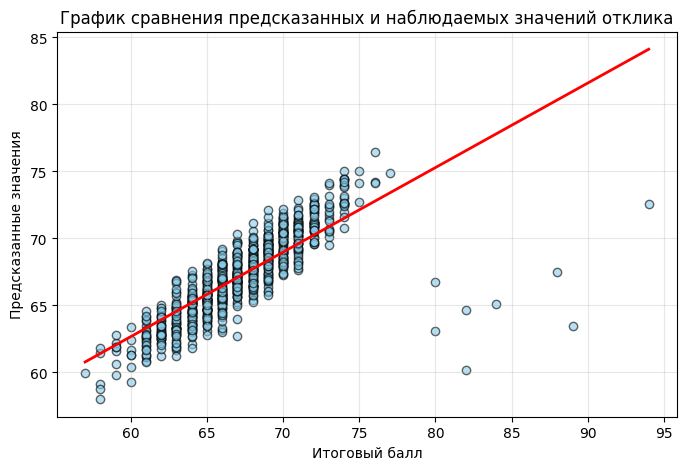

In [5]:
import matplotlib.pyplot as plt

y_exact = y
y_pred = model.fittedvalues

plt.figure(figsize=(8,5))
plt.scatter(y_exact, y_pred, alpha=0.6, color = "skyblue", edgecolor="black")
coeff = np.polyfit(y_exact, y_pred, 1)
x_line = np.linspace(min(y_exact), max(y_exact), 200)
y_line = np.polyval(coeff, x_line)
plt.plot(x_line, y_line, color="red", linewidth=2)
plt.xlabel("Итоговый балл")
plt.ylabel("Предсказанные значения")
plt.title("График сравнения предсказанных и наблюдаемых значений отклика")
plt.grid(alpha=0.3)
plt.show()

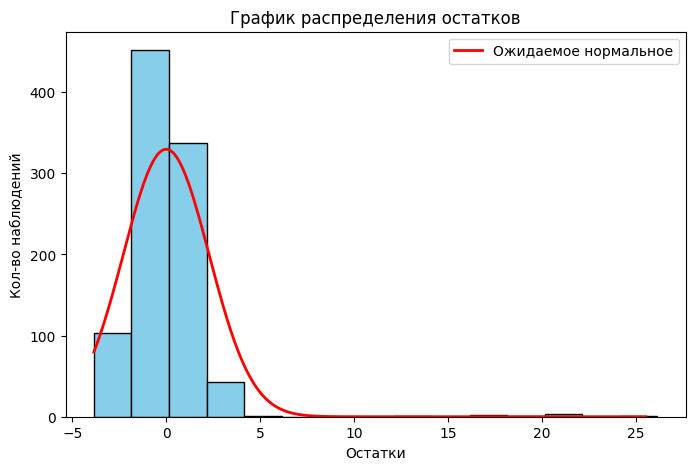

In [6]:
from scipy.stats import norm

residuals = model.resid.dropna()
mu, sigma = norm.fit(residuals)
x = np.linspace(residuals.min(), residuals.max(), 400)
bin_width = 2
bins = np.arange(residuals.min(), residuals.max() + bin_width, bin_width)
hist_counts, hist_edges = np.histogram(residuals, bins=bins)
pdf = norm.pdf(x, mu, sigma)
pdf_scaled = pdf * len(residuals) * bin_width

plt.figure(figsize=(8, 5))
plt.bar(hist_edges[:-1], hist_counts, width=bin_width, align="edge", edgecolor="black", color="skyblue")
plt.plot(x, pdf_scaled, color="red", linewidth=2, label="Ожидаемое нормальное")
plt.xlabel("Остатки")
plt.ylabel("Кол-во наблюдений")
plt.title("График распределения остатков")
plt.legend()
plt.show()

По данной гистограмме можно судить о соответствии распределения остатков нормальному закону со средним значением 0, что говорит об адекватности модели.

Само уравнение регрессии выглядит следующим образом:

In [7]:
s = f"Итоговый балл = {params.iloc[0]} + "
for i in range(1, len(params)):
    s += f"{params.iloc[i]} * {params.index[i]} + "
print(s[:len(s)-3])

Итоговый балл = 42.018038462913864 + 0.29451629191574014 * study_hours_week + 0.1951296078367486 * attendance_pct + 0.04061651975555497 * prev_exam_score + 0.46890746002261396 * tutoring_sessions_month
